# Ground-State: Ising model

Heavily inspired by NetKet's tutorial and Filippo Vicentini's tutorials:
* https://netket.readthedocs.io/en/latest/
* https://github.com/philipvinc

In this Tutorial we will introduce the open-source package NetKet, and show some of its functionalities. 

We will focus on the transverse-field Ising model
$$
H = -h \sum_i \sigma_i^x - J \sum_{⟨i,j⟩} \sigma_i^z \sigma_j^z
$$
in 1D ($i=0,1,\dots,N-1$) with periodic boundary conditions $i=0=N$, and we will try to find its ground state in the critical point $h_c = 1$.

**Note**: In papers and in Netket, one can find definitions with different signs.

## Installation

In your shell:
```shell
pip install --quiet  netket
```
or in Colab
```shell
!pip install --quiet netket
```

Before we check the installation, let us define an environment variable:

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"


Jax, on which NetKet is built, can perform calculations on GPU.
However, GPU is slower for systems smaller than 40 spins.

Now, check if the installation was sucessful:

In [3]:
import netket as nk
nk.__version__


I0000 00:00:1701255120.868598       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


'3.10.2'

Command `!python3 -m netket.tools.info` gives you information of dependencies.

In [ ]:
!python3 -m netket.tools.info


We will also need many other packages

In [4]:
# NetKet
import netket as nk

# json for saving and reading log files
import json

# Jax and Flax
import jax
import jax.numpy as jnp
import flax.linen as nn

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt


## The standard procedure

1. Define the Hilbert space (degrees of freedom)
2. Define the Hamiltonian (cost function)
3. Define the model (neural network)
4. Define the variational quantum state (wrapper around the model)
5. Define the optimization procedure (ground state, steady-state, time evolution)
6. Run

In NetKet this corresponds to NetKet's modules:

1. `netket.graph` and `netket.hilbert`
2. `netket.operator`
3. `netket.models` or `flax.linen`
4. `netket.sampler` and `netket.vqs`
5. `netket.optimizer` and `netket.driver`

This structure is also completely replicated on NetKet's documentation site:
https://netket.readthedocs.io/

## 1. Hilbert space

Although slighlty more complicated, it is best to define the geometry via graphs.

In [5]:
N = 16
g = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)
# We could also use Chain(lenght=N, pbc=True)


And then define the Hilbert space

In [6]:
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)  # We could just provide N=N


#### Extra information

Why using graphs at all?
We only needed `g.n_nodes` above.

<Axes: >

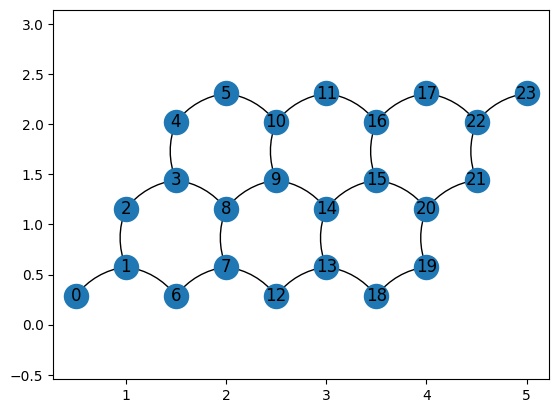

In [5]:
# More complex geometry - honeycomb
_g_hc = nk.graph.Honeycomb(extent=(4,3), pbc=False)
_g_hc.draw()


In [6]:
# Graphs provide symmetries
σ = jnp.ones((N,))
σ = σ.at[0].set(-1)
(g.translation_group(0)@σ)[:5]
# There is also reflection symmetry


Array([[-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.]], dtype=float64)

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 16
g.edges: [(0, 1), (9, 10), (13, 14), (1, 2), (10, 11), (3, 4), (12, 13), (2, 3), (6, 7), (4, 5), (8, 9), (0, 15), (5, 6), (11, 12), (14, 15), (7, 8)]


<Axes: >

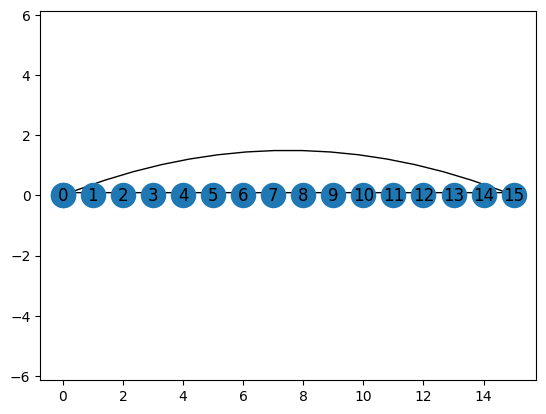

In [7]:
# Graphs provide information we can use to build Hamiltonians

# The number of sites (called nodes):
print("g.n_nodes:", g.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in g.nodes()])
# You can check the number of edges:
print("g.n_edges:", g.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", g.edges())

g.draw()


In [8]:
# Useful Hilbert space methods and attributes
print(f"Number of all states: {hi.n_states}")

x = np.ones((2, N))
x[0,0] = -1
x[0,8:] = -1
print(f"We can get index of a state: {hi.states_to_numbers(x)}")

# We can get all states  -- (2**N, N) large array!
# hi.all_states()


Number of all states: 65536
We can get index of a state: [32512 65535]


In [9]:
# Spaces with constraints
# Usage: Heisenberg model where ground state has total sz = 0

N = 10
_hi = nk.hilbert.Spin(s=1 / 2, N=N)
print(f"Unconstrained Hilbert space of N={N} 1/2-spins")
print(f"    Number of states: {_hi.n_states: 10,d}")

total_sz = 0
_hi = nk.hilbert.Spin(s=1 / 2, N=N, total_sz=total_sz)
print(f"*Constrained* Hilbert space of N={N} 1/2-spins with total s_z = {total_sz}")
print(f"    Number of states: {_hi.n_states: 10,d}")
print( "  **Be careful with Markov chain sampling!**")


Unconstrained Hilbert space of N=10 1/2-spins
    Number of states:      1,024
*Constrained* Hilbert space of N=10 1/2-spins with total s_z = 0
    Number of states:        252
  **Be careful with Markov chain sampling!**


## 2. Hamiltonian

NetKet is built on `LocalOperators`.
We have some predefined Hamiltonians:
* `netket.operator.Ising`
* `netket.operator.Heisenberg`
* `netket.operator.BoseHubbard`

and operators
* `netket.operator.spin`: `sigmap`, `sigmam`, `sigmax`, `sigmay`, `sigmaz`, `identity`
* `netket.operator.boson`: `number`, `proj`, `create`, `destroy`, `identity`

Each `LocalOperator` is a sum of finite many `k`-local operators. For examole, $\sigma^x$ is 1-local and $\sigma_i^z \sigma_j^z$ is 2-local.
We need localness in the calculation of _local operator_, e.g. $E_{loc}(\mathbf{x})$.

Each local operator takes as argument Hilbert space and the site it is acting on.
We can easily combine operators:



In [7]:
from netket.operator.spin import sigmax, sigmaz


In [11]:
_hi_small = nk.hilbert.Spin(s=1/2, N=3)
# Sum of operators
_op = sigmax(_hi_small, 0 ) + sigmaz(_hi_small, 2)  # = σ_0^z + σ_2^z
print(_op.to_dense())
# or a product
_op = sigmax(_hi_small, 0 ) * sigmaz(_hi_small, 2)  # = σ_0^z·σ_2^z
print(_op.to_dense())
# You can also use sum(...)
_op = sum([sigmax(_hi_small, i) for i in range(3)])


[[ 1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0. -1.]]
[[ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]]


**Assignment:** define the 1D transverse-field Ising Hamiltonian with $h=J=1$. Be careful with the signs!

In [ ]:
h, J = 1, 1
ham = ...


In [10]:
# If you are correct, this should work:
ham_nk = nk.operator.Ising(hi, graph=g, h=h, J=-J)   # Note -J !!!
assert np.sum(np.abs(ham.to_sparse() - ham_nk.to_sparse())) < 1e-14


#### Extra information

In [14]:
_hi_small = nk.hilbert.Spin(s=1/2, N=3)


We can define custom operators:

In [15]:
_mat = np.array([[1,0,0,0], [0,0,1,0], [0,0,1,0], [1,1,-1,-1]])
_custom_op = nk.operator.LocalOperator(hilbert=_hi_small, operators=_mat, acting_on=[0, 2])
print(_custom_op.to_dense())


[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  1.  0.  0. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.  0. -1. -1.]]


In [16]:
_op = nk.operator.PauliStrings(_hi_small, 'ZXZ', weights=1)
print(_op.to_dense())


[[ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]]


For historical reasons, operators are compiled with Numba and not with Jax.
Now, we can put them into Jax compatible form with:

In [17]:
_ham_jax = ham.to_pauli_strings().to_jax_operator()


Operators need to be compiled (whether Numba or Jax), because they only all non-zero coefficients $O_{ij}$ of some operator $\hat{O}$ given index $i$.
They do that by calculating them and not by storing them.

## 2.b Exact diagonalization

We can diagonalize Hamiltonians for system sizes below ~20 on laptop, up to ~25 on a cluster, above ~25 with a library using MPI and without creating _sparse_ matrix. The limit is about 50 spins (this is only 7×7 system!)

In [11]:
sp_ham = ham.to_sparse()   # Don't try to_dense()!!!

from scipy.sparse.linalg import eigsh

eigvals, eigvecs = eigsh(sp_ham, k=2, which="SA")
E_gs = eigvals[0]
print(f"Ground state energy is: {E_gs:f}")
print(f"The energy gap is: {eigvals[1]-eigvals[0]}")


Ground state energy is: -20.404594
The energy gap is: 0.09825369953900775


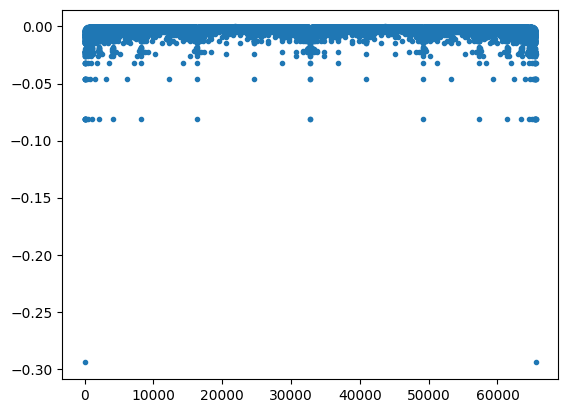

In [20]:
plt.plot(eigvecs[:,0], ".")


## 3. Define a model

Let us study Flax, a library to build neural network models, in a different notebook.

### 3.1 Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i), $$

where the variational parameters are the single-spin wave functions, which we can further take to be normalized: 

$$ |\Phi(\uparrow)|^2 + |\Phi(\downarrow)|^2 =1, $$

and we can further write $ \Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}$. In order to simplify the presentation, we take here and in the following examples the phase $ \phi=0 $. In this specific model this is without loss of generality, since it is known that the ground state is real and positive. 

For the normalized single-spin probability we will take a sigmoid form: 

$$ P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z)), $$

thus depending on the real-valued variational parameter $\lambda$. 
In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$

where $\theta$ is a set of parameters. 
In this case, the parameter of the model will be just one: $\gamma$.  

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. 
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook. 

**Assignment**: Write mean-field model yourselves!
Implement only
$
\sqrt{P(σ; λ)}
$

In [12]:
# Here is a skeleton for help
from typing import Any

class MF(nn.Module):
  fun: Any = nn.log_sigmoid  # log(sigmoid(x)) = -log(1+e^-x)
  @nn.compact
  def __call__(self, x):
    # your code goes here


In [22]:
# Check solution:
variables = {"params":{"lambda": jnp.array([0.5])}}
σ = jnp.array([[1,1,1], [1,-1,-1]])  #Here we can use different Hilbert space, MF ansatz doesn't care
model = MF()
model.apply(variables, σ) - jnp.array([-0.71111548, -1.21111548])  # This should be small


Array([3.72983999e-09, 3.72983977e-09], dtype=float64)

## 4. Variational quantum state

In NetKet we have three variational quantum states
* `netket.vqs.FullSumState`
* `netket.vqs.MCState`
* `netket.vqs.MCMixedState`
* 
As the name suggest, the first one sums over all product states and is thus usable only for small systems.
VQS is the basis of VMC: it allows us to calculate expectation values `.expect(operator)` and even the gradient in parameters in respect to the operator `.expect_and_grad(operator)`

In [14]:
model = MF()
vqs_fs = nk.vqs.FullSumState(hi, model)

sampler = nk.sampler.MetropolisLocal(hi)
vqs_mc = nk.vqs.MCState(sampler, model, n_samples=2048)

vqs_fs.variables = vqs_mc.variables  # So that we have the same parameters  - remember model does not have parameters!


`FullSumState` calclulates exactly $\langle \Psi | \hat{O} | \Psi \rangle$

In [24]:
print(vqs_fs.expect(ham))

# Equivalent to:
Ψ = vqs_fs.to_array()
eng = Ψ.conj().T@(ham.to_sparse() @ Ψ)


-1.600e+01 ± 0.000e+00 [σ²=1.600e+01]


`MCState` does a MCMC integration 
$$
\langle O \rangle = \frac{1}{N_s} \sum_{i=1}^{N_s} O_{loc}(\sigma_i)
$$
and therefore has some uncertianity.

In [25]:
vqs_mc.expect(ham)


-16.101 ± 0.088 [σ²=16.553, R̂=1.0049]

What are those numbers?
The `Stats` object contains the following diagnostics:
* The `Mean` over the local energy samples, which is an estimate of the quantum expectation value $\langle \hat H \rangle.$
* The `Variance` over the local energy samples, which is an estimate of the quantum variance $\langle(\delta\hat H)^2\rangle = \langle (\hat H - \langle \hat H \rangle)^2 \rangle.$
* The Monte Carlo standard error (MCSE) of the mean (as `Sigma`).
* An estimate `TauCorr` of the autocorrelation time over the Markov chains.
* `R_hat`, which is the so-called Gelman-Rubin split-R_hat diagnostic, which indicates whether the MCMC chain is converged (should be below $1.1$).


In [26]:
# Just to show variance is lower close to the eigenstate
old_variables = vqs_mc.variables
vqs_mc.variables = {"params":{"lambda": jnp.array([2*np.log(2+np.sqrt(3))])}}
print(vqs_mc.expect(ham)) # Much smaller variance!

vqs_mc.variables = old_variables


-20.028 ± 0.024 [σ²=1.069, R̂=1.0060]


Finally, calculation of gradient:

In [27]:
vqs_mc.expect_and_grad(ham)


(-16.050 ± 0.087 [σ²=16.034, R̂=1.0020],
 {'lambda': Array([-0.25147858], dtype=float64)})

#### Extra information

Calculation is already performed on all cores:

In [28]:
vqs_mc.samples.shape  # 16 cores × 128 samples = 2048  (× 16 spins)


(16, 128, 16)

Samples are not updated automatically.

In [29]:
print(vqs_mc.expect(ham))
print(vqs_mc.expect(ham))

vqs_mc.sample(chain_length = 1024)  # It is better to define chain_length instead of n_samples
print(vqs_mc.expect(ham))
print(vqs_mc.samples.shape)


-16.050 ± 0.087 [σ²=16.034, R̂=1.0020]
-16.050 ± 0.087 [σ²=16.034, R̂=1.0020]
-15.977 ± 0.031 [σ²=15.897, R̂=1.0008]
(16, 1024, 16)


## 5. Calculating the ground state

**Assignment**
We know how to calculate energy and its gradient. Optimization should now be simple. Do it yourselves!

Hint: We cannot change the value of parameters in `vqs_mc` but we can change the whole dictionary.
```
# Does not work
vqs_mc.parameters["lambda"] = ...
# Does work
vqs_mc.parameters = {"lambda": }
```

In [ ]:
from tqdm import tqdm  # Just a nice "print(i)" in for loop

vqs_mc = nk.vqs.MCState(sampler, model, n_samples=1024)

learning_rate = 0.2
n_steps = 1000
stats = np.zeros((n_steps, 2))  # We store energy and variance
for i in tqdm(range(n_steps)):
  # You should do it in 4-8 lines of code
  ...


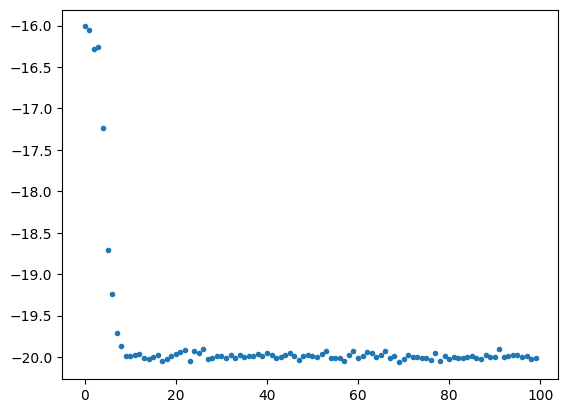

In [31]:
# You should get something like this
plt.plot(stats[:,0], ".")


#### Using NetKet's optimization driver

Basically, this is the stochastic gradient descent implemented in NetKet.
Of course, NetKet has more support infrastructure.

In [37]:
# First we reset the parameters to run the optimization again
vqs_mc.init_parameters()

# Then we create an optimizer from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.2)

# json logger
log = nk.logging.JsonLog(output_prefix="MF_log")

# build the optimization driver
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc)

# run the driver for 100 iterations. This will display a progress bar
# by default.
# We can also add additional observables
op_spin_x = sum([sigmax(hi,i) for i in g.nodes()])
gs.run(n_iter=100, out=log, obs={"tot_spin_x": op_spin_x})


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 28.52it/s, Energy=-20.024 ± 0.037 [σ²=1.274, R̂=1.0118]]


(JsonLog('MF_log', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.016536951065063477
   	Params: 0.0018010139465332031,)

In [38]:
with open("MF_log.log") as f:
  log = json.load(f)
log.keys()


dict_keys(['tot_spin_x', 'Energy'])

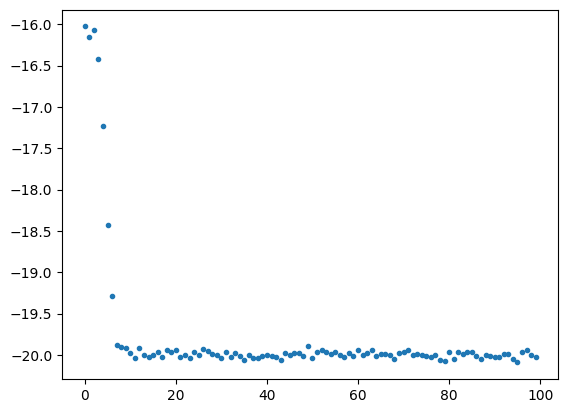

In [39]:
plt.plot(log["Energy"]["iters"], log["Energy"]["Mean"], ".")


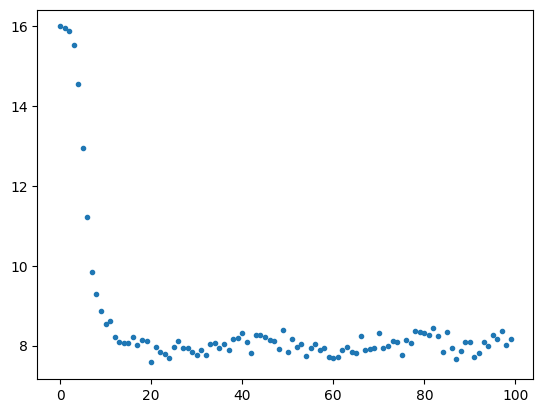

In [42]:
plt.plot(log["tot_spin_x"]["iters"], log["tot_spin_x"]["Mean"], ".")


We have used a small number of samples for optimization.
To actually calculate final energy, we should increase the number of samples.
In this case, ansatz error is much larger than MC error and we do not have to increase the number of samples.

In [43]:
E_mc = vqs_mc.expect(ham)
print(E_mc)
print(f"Final optimized energy = {E_mc.mean}")
print(f"Relative error = {1 - E_mc.mean/E_gs}")


-20.001 ± 0.034 [σ²=1.115, R̂=1.0084]
Final optimized energy = -20.000574442488887
Relative error = 0.01980044409937165


In [45]:
sx = vqs_mc.expect(op_spin_x)
print(sx)
vqs_mc.sample(n_samples=2**14)
sx = vqs_mc.expect(op_spin_x)
print(sx)


8.23 ± 0.12 [σ²=11.51, R̂=1.0238]
8.105 ± 0.037 [σ²=12.048, R̂=1.0017]


## 6. Competition - who will get the lowest energy?

* `vqs_mc.n_parameters` should be about 500
* `n_iter` * `n_samples` should be about 1e6

#### Group 1: Study MF with a phase


Add a phase to the mean-field model and make sure that it doesn't affect the results.

Use: `nn.initializers.uniform(scale=2*jnp.pi)` as an initializer for phase

Use function
```
def log_extra(step, logdata, driver):
  logdata["params"] = driver.state.parameters
  return True
```
to store additional data during run
```
gs.run(n_iter=n_iter, out=log, callback=log_extra)
```

In [ ]:
n_iter = 1024
n_samples = 512

# Add code
class MF_phase(nn.Module):
  ...

# Add code

def log_extra(step, logdata, driver):
  logdata["params"] = driver.state.parameters
  return True

gs.run(n_iter=n_iter, out=log, callback=log_extra)


#### Group 2: Calculate correlations

Optimize and plot $\langle \sigma_0^z \sigma_j^z \rangle$ vs $j$.
Note that $j=0,1,2,...,N$ 
Calculate with two `nk.vqs.MCState` for mean field and RBM ansatz.
Also compare the final energies.
For final sampling use $20000$ samples.

In [117]:
model_mf = MF()
model_rbm = nk.models.RBM(alpha=2)

n_iter = 1024
n_samples = 512
vqs_mf = nk.vqs.MCState(sampler, model_mf, n_samples=n_samples)
...


Ellipsis

#### Group 3: RBMs and different optimizers

Study the performance of different optimizers!

In [265]:
n_iter = 1024
n_samples = 512
model = nk.models.RBM(alpha=2)
vqs_mc = nk.vqs.MCState(sampler, model, n_samples=n_samples)

# SGD:
optimizer = nk.optimizer.Sgd(learning_rate=)  # Try different learning rates
# Adam
optimizer = nk.optimizer.Adam(learning_rate=)  # Try different learning rates
# Stochastic reconfiguration
optimizer = nk.optimizer.Sgd(learning_rate=)  # Try different learning rates
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc, preconditioner=nk.optimizer.SR(diag_shift=0.1))


SyntaxError: invalid syntax (1570223130.py, line 7)

#### Group 4: Different networks

Rerun the calculation with different models, try different topology of feed-forward neural network (MLP) while keeping about 550 parameters.

In [207]:
n_iter = 1024
n_samples = 512

# RBM
model = nk.models.RBM(alpha=2)
# Jatrow - same person as RBM
model = nk.models.Jastrow()
# FFN
model = nk.models.MLP(hidden_dims=[])  # Try deep and short-range, shallow and long-range


vqs_mc = nk.vqs.MCState(sampler, model, n_samples=n_samples)
print(vqs_mc.n_parameters)  # This can help

# Use stochastic reconfiguration
optimizer = nk.optimizer.Sgd(learning_rate=0.05)  # Try different learning rates
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc, preconditioner=nk.optimizer.SR(diag_shift=0.1))


SyntaxError: invalid syntax (2701465478.py, line 5)

#### Group 5: Use different combinations of iters and samples

Study the effect of `n_samples` in the calculation while keeping total number of samples `n_samples*n_iter` the same.

In [ ]:
total = 512*1024

model = nk.models.RBM(alpha=2)
vqs_mc = nk.vqs.MCState(sampler, model, n_samples=n_samples)
optimizer = nk.optimizer.Sgd(learning_rate=0.05)
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc, preconditioner=nk.optimizer.SR(diag_shift=0.1))
log = nk.logging.JsonLog(output_prefix=f"N_samples_{n_samples}")
gs.run(n_iter=int(total/n_samples), out=log)


#### Symmetries

In [297]:
symmetries = g.automorphisms()
print(len(symmetries))
for s in symmetries[:4]:
  print(s)


32
Permutation([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
Permutation([0, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])
Permutation([1, 0, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2])
Permutation([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0])


In [301]:
n_iter = 1024
n_samples = 512

model = nk.models.RBMSymm(symmetries=g.translation_group(0), alpha=2)
vqs_mc = nk.vqs.MCState(sampler, model, n_samples=n_samples)
print(vqs_mc.n_parameters)

optimizer = nk.optimizer.Sgd(learning_rate=0.05)  # Try different learning rates
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc, preconditioner=nk.optimizer.SR(diag_shift=0.1))
log = nk.logging.JsonLog(output_prefix=f"RBM_Symm")
gs.run(n_iter=n_iter, out=log)

vqs_mc.sample(n_samples=2**14)
E_mc = vqs_mc.expect(ham)
print(E_mc)
print(f"Final optimized energy = {E_mc.mean}")
print(f"Relative error = {1 - E_mc.mean/E_gs}")


35


100%|██████████| 1024/1024 [00:32<00:00, 31.27it/s, Energy=-20.4020 ± 0.0036 [σ²=0.0066, R̂=1.0321]]


-20.40390 ± 0.00068 [σ²=0.00757, R̂=1.0006]
Final optimized energy = -20.403897768516828
Relative error = 3.414457663875048e-05


In [95]:
n_iter = 1024
n_samples = 512

model = nk.models.GCNN(symmetries=g.translation_group(0), layers=1, features=(4))
vqs_mc = nk.vqs.MCState(sampler, model, n_samples=n_samples)
print(vqs_mc.n_parameters)

optimizer = nk.optimizer.Sgd(learning_rate=0.05)  # Try different learning rates
gs = nk.driver.VMC(ham, optimizer, variational_state=vqs_mc, preconditioner=nk.optimizer.SR(diag_shift=0.1))
log = nk.logging.JsonLog(output_prefix=f"GCNN")
gs.run(n_iter=n_iter, out=log)

vqs_mc.sample(n_samples=2**14)
E_mc = vqs_mc.expect(ham)
print(E_mc)
print(f"Final optimized energy = {E_mc.mean}")
print(f"Relative error = {1 - E_mc.mean/E_gs}")


68


100%|██████████| 1024/1024 [00:40<00:00, 25.36it/s, Energy=-20.315+0.000j ± 0.027 [σ²=0.369, R̂=1.0114]]


-20.3142+0.0000j ± 0.0044 [σ²=0.3034, R̂=1.0006]
Final optimized energy = (-20.31415600960441+0j)
Relative error = (0.004432259865008725+0j)
